In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 10

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 50,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:7' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': .0,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=10_epoch=5_lr=0.001_alpha=0.001_tau=50


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.093206283823536e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 2.9797873065650604e-05, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.974790957018768e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.5865623109905715e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.355548640801164e-05, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
Elapsed time(grad):12.432
losses=tensor([[3.2053e-04, 1.4590e-03, 9.3039e+00, 9.3235e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):8.037
Fairne

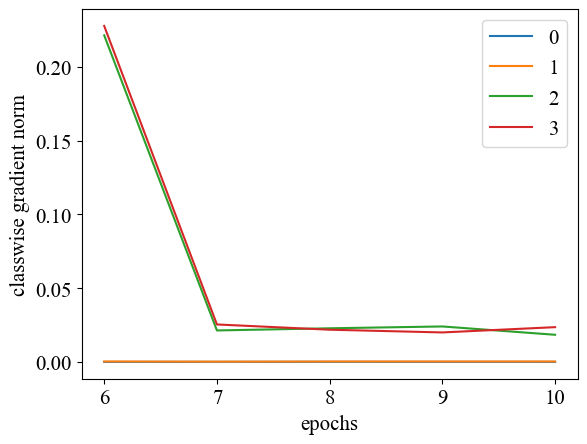

---------------------------- Task 3 -----------------------
Elapsed time(grad):16.094
losses=tensor([[2.0189e-04, 4.7948e-04, 6.0193e-02, 5.8864e-02, 1.0199e+01, 1.2422e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.277
Fairness:[ 0.4811675   0.48798314  0.32664284  0.06119488 -0.4770387  -0.87995039]
Current class expected loss:[0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=11263
[11] Eval metrics for task 1 >> {'accuracy': 0.9401712667445833, 'loss': 0.0010889180339256359, 'std': 0.022824327969073077, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8347417299869522, 'loss': 0.0027808034455040643, 'std': 0.024664210607107218, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9612246901628414, 'loss': 0.0005398139977785923, 'std': 0.029610340387056733, 'EER': -1}
Elapsed time(grad):9.506
losses=tensor([[0.0010, 0.0008, 0.0006, 0.0015, 0.0884, 0.2014]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.3

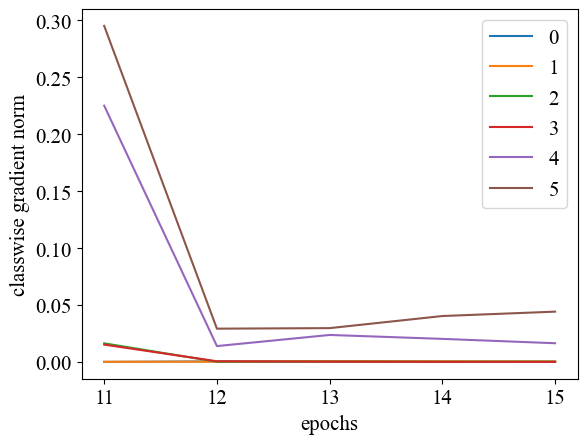

---------------------------- Task 4 -----------------------
Elapsed time(grad):9.128
losses=tensor([[1.2155e-04, 9.9949e-04, 6.7111e-04, 2.0952e-04, 3.4251e-02, 3.9982e-01,
         1.3316e+01, 1.1192e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):16.638
Fairness:[ 0.24564017  0.34944515  0.3392234   0.28690427 -0.1299403   0.08309041
 -0.74164352 -0.43271984]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=12183
[16] Eval metrics for task 1 >> {'accuracy': 0.9365076867751505, 'loss': 0.0011950508006639232, 'std': 0.021201564326170985, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.8107797989101235, 'loss': 0.003988482634537834, 'std': 0.027834062476015053, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.9002938544016512, 'loss': 0.001650094842834432, 'std': 0.05388129834783961, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9601187623372298, 'loss': 0.0005886224806608871, 'std': 0.002916

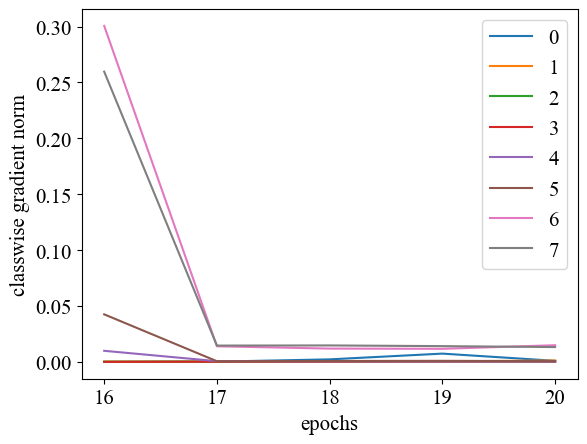

---------------------------- Task 5 -----------------------
Elapsed time(grad):12.996
losses=tensor([[5.8340e-04, 6.5661e-03, 7.7281e-04, 9.5833e-04, 9.4923e-04, 1.4201e-03,
         6.7341e-02, 5.6591e-03, 1.3533e+01, 1.4596e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):20.11
Fairness:[ 0.20013904  0.26977188  0.23648813  0.25731061  0.15179836  0.17971556
  0.15893476  0.01260685 -0.70443532 -0.76232987]
Current class expected loss:[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
len(updated_seq_indices)=11800
[21] Eval metrics for task 1 >> {'accuracy': 0.9253775959723096, 'loss': 0.0015471609912583732, 'std': 0.01823473882945248, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7639611635582163, 'loss': 0.0052398025814396395, 'std': 0.000395272085348064, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.8239522161234052, 'loss': 0.003241720582530491, 'std': 0.021261633163763893, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.869249733

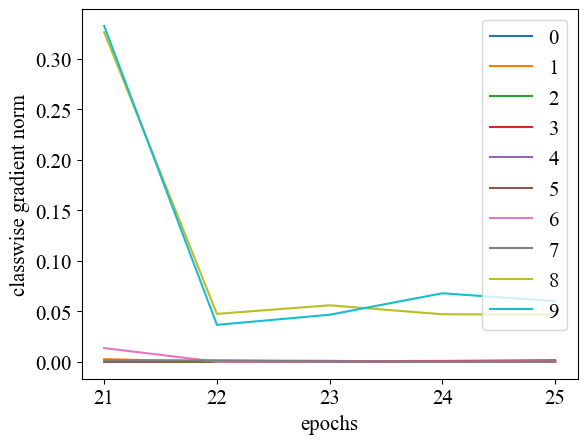

final avg-acc 0.8533912941483507
final avg-forget 0.11874882593373201


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.971, 0.962, 0.   , 0.   , 0.   ],
       [0.951, 0.843, 0.934, 0.   , 0.   ],
       [0.923, 0.803, 0.913, 0.954, 0.   ],
       [0.909, 0.734, 0.857, 0.875, 0.893]])

In [7]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9254151265825469

In [8]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.004, 0.044, 0.048, 0.048]

In [9]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.028813602519308285

In [10]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.011, 0.067, 0.063, 0.068]

In [11]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.04221485293325171

In [12]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9254151265825469
EER:0.028813602519308285
std:0.04221485293325171
